In [1]:
import numpy as np
import pandas as pd
import os

In [3]:
import glob
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras

from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import random

In [5]:
import sys
import io

In [7]:
plt.rcParams['font.family'] = 'Malgun Gothic'

In [9]:
!pip install pyaudio

In [11]:
!pip install wave

In [13]:
loaded_gender_model = tf.keras.models.load_model('gender_model.h5')
loaded_emotion_model = tf.keras.models.load_model('emotion_model.h5')

In [15]:
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
%matplotlib inline
import os
import pandas as pd
import librosa
import glob
import matplotlib.pyplot as plt

In [19]:
import scipy.io.wavfile
import numpy as np
import sys
from IPython.display import Audio

In [21]:
def extract_mfcc(file_path):
    audio, sr = librosa.load(file_path)
    total_duration = librosa.get_duration(y=audio, sr=sr)
    duration = min(max(total_duration * 0.9, 3), 10)
    audio, sr = librosa.load(file_path, duration=duration)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    if mfcc.shape[1] < 400:
        mfcc = np.pad(mfcc, ((0, 0), (0, 400 - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :400]
    return mfcc

* 녹음을 시작합니다.
* 녹음이 완료 되었습니다.
Wav length: 4.9923125, Mel_S shape: (100, 500)


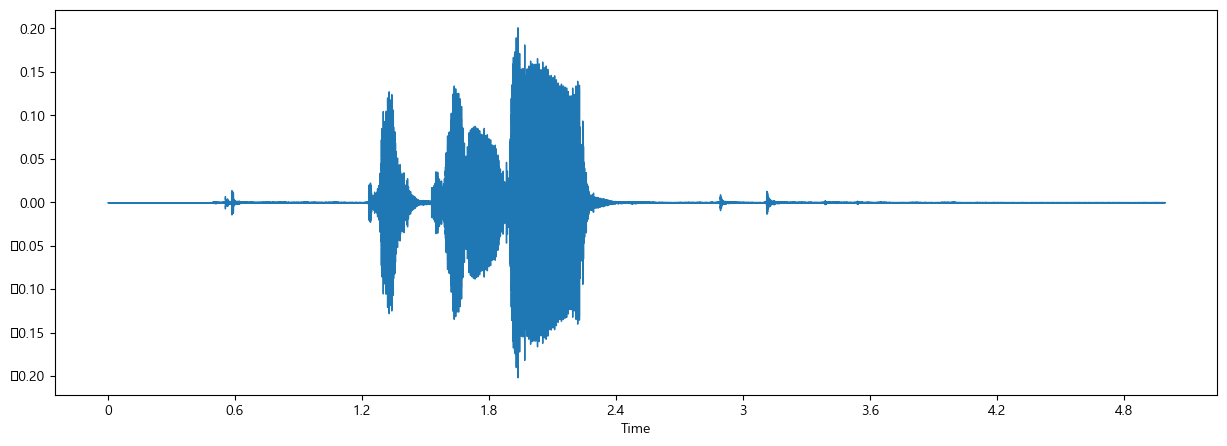

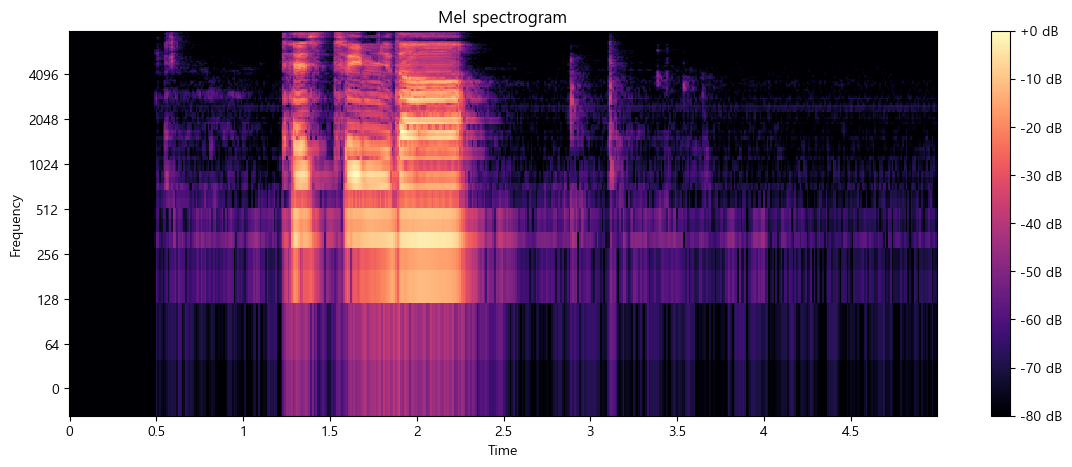

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
예측된 성별: 남성
예측된 감정: 행복


In [53]:
import pyaudio
import wave

CHUNK = 1024 
FORMAT = pyaudio.paInt16 #paInt8
CHANNELS = 2 
RATE = 44100 #sample rate
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = "output10.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK) #buffer

print("* 녹음을 시작합니다.")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data) # 2 bytes(16 bits) per channel

print("* 녹음이 완료 되었습니다.")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

#음성 파형 보이기
data1, sampling_rate = librosa.load('output10.wav')
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data1, sr=sampling_rate)

#음성 스펙트럼 보기
data1, sampling_rate = librosa.load('output10.wav', sr=16000)

frame_length = 0.025
frame_stride = 0.010
input_nfft = int(round(sampling_rate * frame_length))
input_stride = int(round(sampling_rate * frame_stride))

S = librosa.feature.melspectrogram(y=data1, n_mels=100, n_fft=input_nfft, hop_length=input_stride)
print("Wav length: {}, Mel_S shape: {}".format(len(data1) / sampling_rate, np.shape(S)))

S_dB = librosa.power_to_db(S, ref=np.max)

fig = plt.figure(figsize=(14, 5))
librosa.display.specshow(S_dB, sr=sampling_rate, hop_length=input_stride, x_axis='time', y_axis='log')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Mel spectrogram")
plt.show()

#특징 추출
new_file_path = 'output10.wav'  # 새로운 오디오 파일 경로
new_mfcc = extract_mfcc(new_file_path)        # MFCC 추출
new_mfcc = np.expand_dims(new_mfcc, axis=0)   # 배치 차원 추가
new_mfcc = np.expand_dims(new_mfcc, axis=-1)  # 채널 차원 추가

# 성별 예측
gender_prediction = loaded_gender_model.predict(new_mfcc)
predicted_gender_class = np.argmax(gender_prediction, axis=1)[0]
predicted_gender = '남성' if predicted_gender_class == 1 else '여성'

# 감정 예측
emotion_prediction = loaded_emotion_model.predict(new_mfcc)
predicted_emotion_class = np.argmax(emotion_prediction, axis=1)[0]
emotion_labels = {0: '차분함', 1: '행복', 2: '슬픔', 3: '분노', 4: '무서움'}  # 클래스 인덱스와 일치하도록 수정
predicted_emotion = emotion_labels[predicted_emotion_class]

print(f'예측된 성별: {predicted_gender}')
print(f'예측된 감정: {predicted_emotion}')

# 음성 녹음 확인
from IPython.display import Audio

Audio("output10.wav")